# Model calibration: toy problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Times New Roman"],
    }
)
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
def double_banana(x, peaks=(1.0, 1.5), offsets=(0.0, 6.0), scales=(0.1, 0.2), curvatures=(-1, 1)):
    x1, x2 = x
    bananas = [
        peak * np.exp(-scale * ((x2 - curvature * (x1 - offset)**2) ** 2 + (x1 - offset - 2) ** 2))
        for peak, offset, scale, curvature in zip(peaks, offsets, scales, curvatures)
    ]
    return sum(bananas)

In [3]:
posterior = double_banana

8.06532663316583 4.2713567839196


([], [])

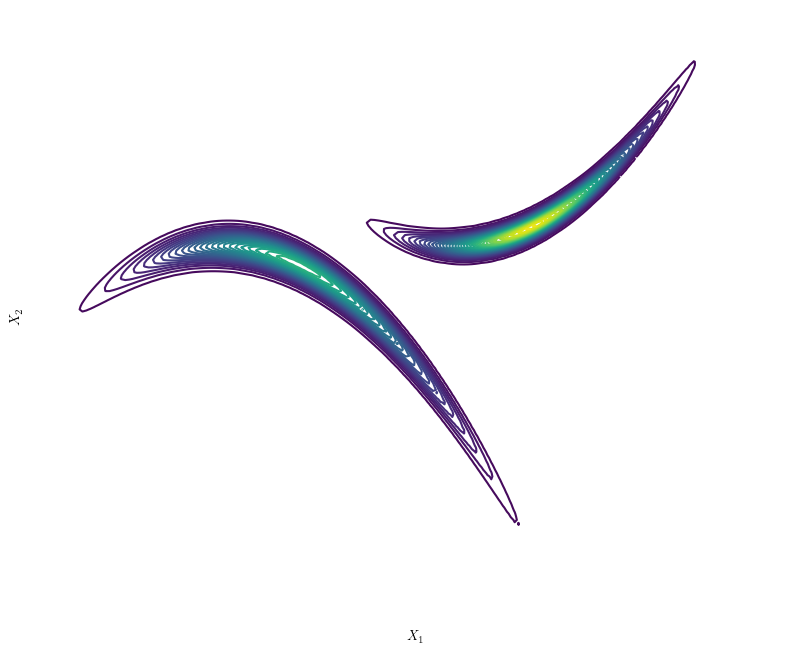

In [4]:
x1_range = np.linspace(-5, 15, 200)
x2_range = np.linspace(-80, 50, 200)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = np.array([[posterior((x1, x2)) for x1 in x1_range] for x2 in x2_range])
Z = np.where(Z > 0.01, Z, np.nan)

max_index = np.unravel_index(np.nanargmax(Z), Z.shape)
x1_max, x2_max = X1[max_index], X2[max_index]
print(x1_max, x2_max)

plt.figure(figsize=(10, 8))
plt.contour(X1, X2, Z, levels=40, cmap='viridis')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])

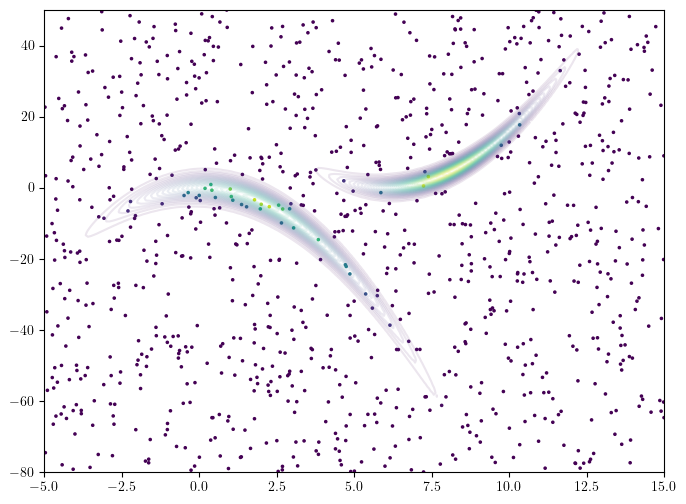

In [5]:
doe = 1000
x1 = np.random.uniform(-5, 15, doe)
x2 = np.random.uniform(-80, 50, doe)
y = posterior((x1, x2))

plt.figure(figsize=(8, 6))
plt.contour(X1, X2, Z, levels=40, cmap='viridis', alpha=0.1)
plt.scatter(x1, x2, c=y, s=2.5)

In [6]:
import GPy

X = np.vstack((x1, x2)).T
y = y.reshape(-1, 1)
kernel = GPy.kern.Matern32(input_dim=2, ARD=True)

gp = GPy.models.GPRegression(X, y, kernel)
gp.optimize(messages=True)
print(gp.kern.lengthscale)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s09  0001   1.222357e+03   5.210209e+04 
    00s17  0002   9.737867e+02   7.177910e+04 
    01s17  0019  -1.502585e+03   3.405394e-01 
    02s20  0038  -1.502761e+03   8.838336e-05 
Runtime:     02s20
Optimization status: Converged

  index  |  GP_regression.Mat32.lengthscale  |  constraints  |  priors
  [0]    |                       1.11758598  |      +ve      |        
  [1]    |                       3.75483454  |      +ve      |        


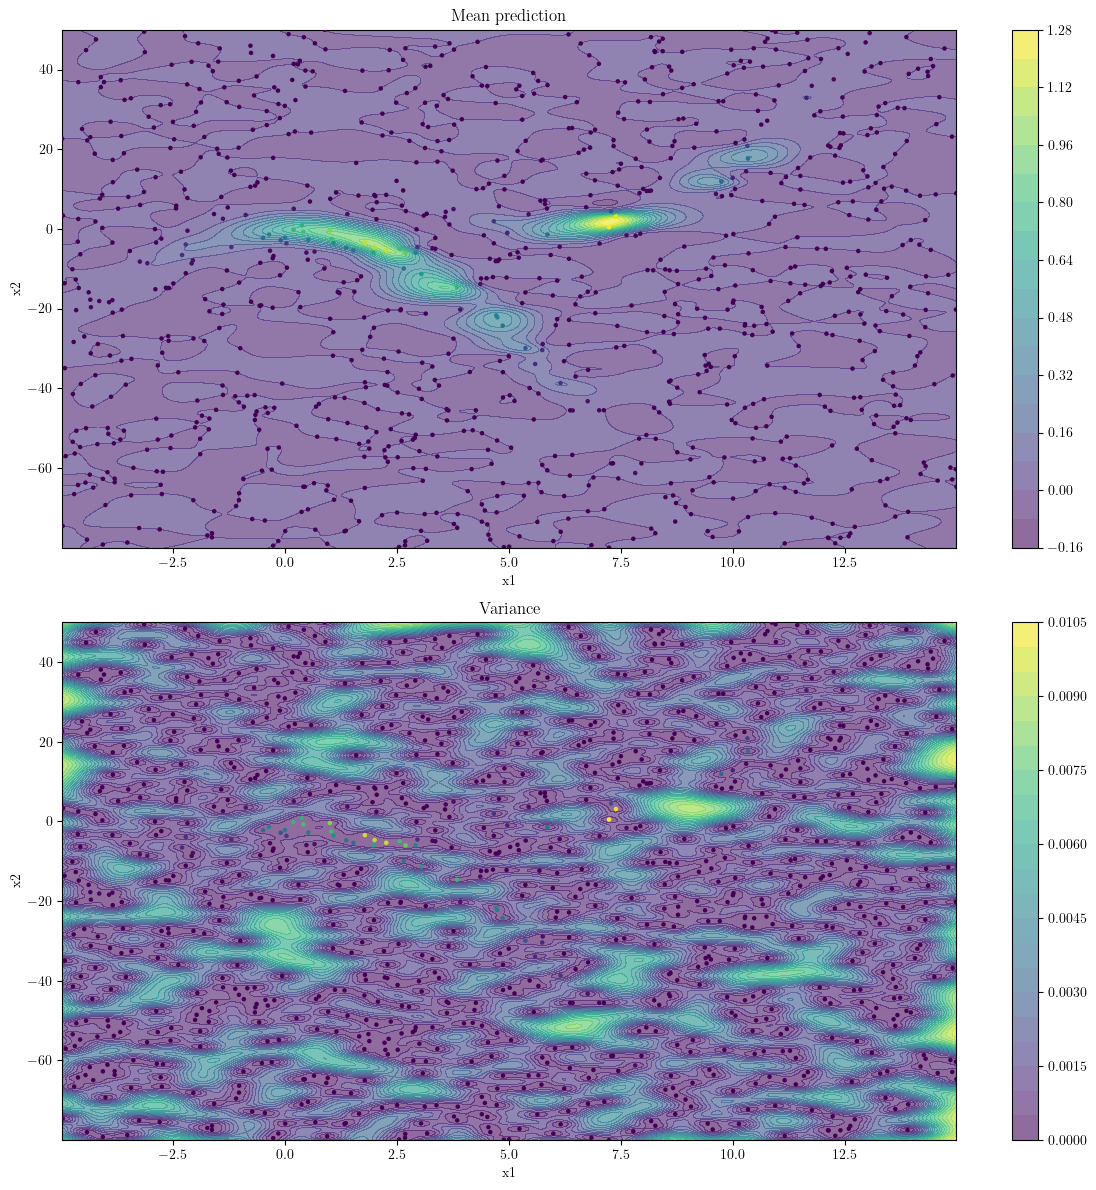

In [7]:
x1_grid, x2_grid = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), 1000),
    np.linspace(X[:, 1].min(), X[:, 1].max(), 1000)
)
X_pred = np.column_stack([x1_grid.ravel(), x2_grid.ravel()])

mean, variance = gp.predict(X_pred)
mean = mean.reshape(x1_grid.shape)
variance = variance.reshape(x2_grid.shape)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Mean plot
scatter = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=5, zorder=5)
contour_mean = ax1.contourf(x1_grid, x2_grid, mean, levels=20, cmap='viridis', alpha=0.6)
ax1.set_title('Mean prediction')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
fig.colorbar(contour_mean, ax=ax1)

# Variance plot
scatter = ax2.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=5, zorder=5)
contour_variance = ax2.contourf(x1_grid, x2_grid, variance, levels=20, cmap='viridis', alpha=0.6)
ax2.set_title('Variance')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
fig.colorbar(contour_variance, ax=ax2)

plt.tight_layout()